In [ ]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 358 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 30.3 MB/s 
     |████████████████████████████████| 168 kB 75.4 MB/s 
     |████████████████████████████████| 182 kB 56.2 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 140 kB 69.9 MB/s 


In [ ]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [ ]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Training Config
config = {
    "batch_size" : 32,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 60,
    "feature_dim" : 6,
    "hidden_dim" : 32,
    "output_dim" : 1,
    "num_layers" : 3,
    "dropout" : 0.2
}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


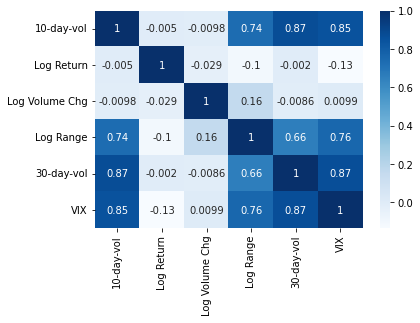

[[ 1.         -0.00501555 -0.00977623  0.73853209  0.87231338  0.85158026]
 [-0.00501555  1.         -0.02887119 -0.10401634 -0.00199862 -0.13446202]
 [-0.00977623 -0.02887119  1.          0.1605345  -0.00856199  0.00992931]
 [ 0.73853209 -0.10401634  0.1605345   1.          0.65985557  0.76029605]
 [ 0.87231338 -0.00199862 -0.00856199  0.65985557  1.          0.86859877]
 [ 0.85158026 -0.13446202  0.00992931  0.76029605  0.86859877  1.        ]]
(8270, 6)


In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                     'Log Adj Close', 'Log Return', 'Log Volume', 'Log Volume Chg', 'Log Range', '10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * self.scaling_factor
        data["Log Volume"] = np.log(data["Volume"])
        data["Log Volume Chg"] = np.insert(np.diff(data["Log Volume"]), 0, 0)
        data["Log Range"] = np.log(data["High"] / data["Low"]) * self.scaling_factor
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        data["30-day-vol"] = data["Log Return"].rolling(30).std(ddof=0)

        return data

    def get_vix_data(self):
        """
        Output:
        raw vix data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        """
        data = yf.download("^VIX", start = self.start, end = self.end, interval = self.freq)
        
        return data
    
    def prepare_data(self, *args):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Input:
        Multiple types of data:
        Basic data: 10-day-vol, Log Volume Chg, Log Range
        Optional data: VIX?

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization

        Current features:
        [10-day-vol, Log Return, Log Volume Chg, Log Range, 30-day-vol, VIX]
        Update based on correlation [10-day-vol, Log Range, 30-day-vol, VIX]
        """
        data = args[0]
        vol_10 = data['10-day-vol'].values.reshape(-1, 1)
        log_return = data['Log Return'].values.reshape(-1, 1)
        log_vlmchg = data['Log Volume Chg'].values.reshape(-1, 1)
        log_range = data['Log Range'].values.reshape(-1, 1)
        vol_30 = data['30-day-vol'].values.reshape(-1, 1)
        
        dataset = vol_10
        dataset = np.append(dataset, log_return, axis=1)
        dataset = np.append(dataset, log_vlmchg, axis = 1)
        dataset = np.append(dataset, log_range, axis = 1)
        dataset = np.append(dataset, vol_30, axis = 1)
        
        # For appending more types of data -> VIX
        for i in range(1, len(args)):
            extra_data = args[i]['Adj Close'].values.reshape(-1, 1)
            dataset = np.append(dataset, extra_data, axis = 1)

        dataset = dataset[31:]
        corr_mtx = np.corrcoef(dataset, rowvar=False)

        df = pd.DataFrame(corr_mtx, columns = ['10-day-vol','Log Return','Log Volume Chg', 'Log Range', '30-day-vol', 'VIX'], \
                          index = ['10-day-vol','Log Return','Log Volume Chg', 'Log Range', '30-day-vol', 'VIX'])
        hm = sn.heatmap(data = df, cmap="Blues", annot=True)
        plt.show()
        print(corr_mtx)
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, vol_10, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
# print(np.shape(data))
# print(data)
# print("#######################################################################")
vix_data = volatiltiy_data.get_vix_data()
# print(np.shape(vix_data))
# print(vix_data)
# print("#######################################################################")
dataset, vol_10, scaler = volatiltiy_data.prepare_data(data, vix_data)
print(np.shape(dataset))
# print(dataset)

In [ ]:
# df = data.copy()

# df['VIX'] = vix_data['Adj Close']
# df['Y'] = list(df['10-day-vol'])[1:] + [0]
# df.iloc[31:, :].corr()

In [ ]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, vol_10, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.vol_10 = vol_10
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, self.num_batches, config['feature_dim']))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.vol_10[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps, :]
            label = y[:, index+time_steps].view(self.batch_size, 1)
            index += 1
            yield input, label

In [ ]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, vol_10, batch_size=config["batch_size"], sequence_length=config["look_back"], feature_size=config["feature_dim"])
tmp = iter(dataloader)
input, label = next(tmp) 
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([32, 60, 6])
label shape = torch.Size([32, 1])


In [ ]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        # padding = (kernel_size-1)/2
        self.cnns = torch.nn.Sequential(
            torch.nn.Conv1d(feature_dim, hidden_dim, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.ReLU(inplace=True)
        )
        self.lstm = torch.nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], dropout=config["dropout"], batch_first=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)

    def forward(self, x):
        # x : (batch_size, time_steps, feature_size)
        x = x.permute(0, 2, 1) # x : (batch_size, feature_sizem, time_steps)
        cnn_out = self.cnns(x) # cnn_out : (batch_size, feature_sizem, time_steps)
        rnn_in = cnn_out.permute(0, 2, 1) # rnn_in : (batch_size, time_steps, feature_size)
        x, h = self.lstm(rnn_in)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [ ]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([32, 1])
shape of label : torch.Size([32, 1])
                     Kernel Shape  Output Shape   Params Mult-Adds
Layer                                                             
0_cnns.Conv1d_0        [6, 32, 3]  [32, 32, 60]    576.0    34.56k
1_cnns.BatchNorm1d_1         [32]  [32, 32, 60]     64.0      32.0
2_cnns.ReLU_2                   -  [32, 32, 60]        -         -
3_lstm                          -  [32, 60, 32]  25.344k   24.576k
4_relu                          -      [32, 32]        -         -
5_linear                  [32, 1]       [32, 1]     33.0      32.0
-------------------------------------------------------------------
                       Totals
Total params          26.017k
Trainable params      26.017k
Non-trainable params      0.0
Mult-Adds               59.2k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_cnns.Conv1d_0,"[6, 32, 3]","[32, 32, 60]",576.0,34560.0
1_cnns.BatchNorm1d_1,[32],"[32, 32, 60]",64.0,32.0
2_cnns.ReLU_2,-,"[32, 32, 60]",NaN,NaN
3_lstm,-,"[32, 60, 32]",25344.0,24576.0
4_relu,-,"[32, 32]",NaN,NaN
5_linear,"[32, 1]","[32, 1]",33.0,32.0


In [ ]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]
train_vol_10, val_vol_10, test_vol_10 = vol_10[0:train_size,:], vol_10[train_size:train_size+val_size,:], vol_10[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, train_vol_10, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, val_vol_10, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, test_vol_10, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [ ]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction.flatten(), target.flatten())

        val_loss += loss.item()
        # print(loss.item())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target

    batch_bar.close()
    val_loss /= len(dataloader)

    return val_loss

In [ ]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [ ]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_mult_feats_CNN", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: quantoalpha. Use `wandb login --relogin` to force relogin


In [ ]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})

path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_{:.07}'.format(val_loss)
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler_lr.state_dict(),
            'val_loss': val_loss, 
            'epoch': epoch}, path)
best_val_loss = val_loss
wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.2090109	 Eval Loss 0.3471280	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.0422738	 Eval Loss 0.2921706	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.0363248	 Eval Loss 0.2798666	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.0349169	 Eval Loss 0.2245299	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.0299183	 Eval Loss 0.2196889	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.0297828	 Eval Loss 0.1943334	 Learning Rate 0.0010	



Epoch 7/100: 
	 Train Loss 0.0260094	 Eval Loss 0.1688309	 Learning Rate 0.0010	



Epoch 8/100: 
	 Train Loss 0.0243782	 Eval Loss 0.1459818	 Learning Rate 0.0010	



Epoch 9/100: 
	 Train Loss 0.0215213	 Eval Loss 0.1324271	 Learning Rate 0.0010	



Epoch 10/100: 
	 Train Loss 0.0234954	 Eval Loss 0.1356276	 Learning Rate 0.0010	



Epoch 11/100: 
	 Train Loss 0.0239843	 Eval Loss 0.1364232	 Learning Rate 0.0010	


Epoch 00012: reducing learning rate of group 0 to 7.5000e-04.

Epoch 12/100: 
	 Train Loss 0.0244128	 Eval Loss 0.1416446	 Learning Rate 0.0010	



Epoch 13/100: 
	 Train Loss 0.0226326	 Eval Loss 0.1372865	 Learning Rate 0.0008	



Epoch 14/100: 
	 Train Loss 0.0195175	 Eval Loss 0.1192492	 Learning Rate 0.0008	



Epoch 15/100: 
	 Train Loss 0.0173670	 Eval Loss 0.1152598	 Learning Rate 0.0008	



Epoch 16/100: 
	 Train Loss 0.0158122	 Eval Loss 0.1181017	 Learning Rate 0.0008	



Epoch 17/100: 
	 Train Loss 0.0149139	 Eval Loss 0.1132197	 Learning Rate 0.0008	



Epoch 18/100: 
	 Train Loss 0.0143709	 Eval Loss 0.1181317	 Learning Rate 0.0008	



Epoch 19/100: 
	 Train Loss 0.0139273	 Eval Loss 0.1138766	 Learning Rate 0.0008	



Epoch 20/100: 
	 Train Loss 0.0124956	 Eval Loss 0.1135203	 Learning Rate 0.0008	



Epoch 21/100: 
	 Train Loss 0.0118130	 Eval Loss 0.1151231	 Learning Rate 0.0008	



Epoch 22/100: 
	 Train Loss 0.0117187	 Eval Loss 0.1110882	 Learning Rate 0.0008	



Epoch 23/100: 
	 Train Loss 0.0109330	 Eval Loss 0.1406487	 Learning Rate 0.0008	



Epoch 24/100: 
	 Train Loss 0.0109476	 Eval Loss 0.1125809	 Learning Rate 0.0008	



Epoch 25/100: 
	 Train Loss 0.0115034	 Eval Loss 0.1172607	 Learning Rate 0.0008	



Epoch 26/100: 
	 Train Loss 0.0101833	 Eval Loss 0.1168946	 Learning Rate 0.0008	



Epoch 27/100: 
	 Train Loss 0.0098683	 Eval Loss 0.1171788	 Learning Rate 0.0008	



Epoch 28/100: 
	 Train Loss 0.0093522	 Eval Loss 0.1142994	 Learning Rate 0.0008	



Epoch 29/100: 
	 Train Loss 0.0099234	 Eval Loss 0.1480540	 Learning Rate 0.0008	



Epoch 30/100: 
	 Train Loss 0.0095339	 Eval Loss 0.1094811	 Learning Rate 0.0008	


Epoch 00031: reducing learning rate of group 0 to 5.6250e-04.

Epoch 31/100: 
	 Train Loss 0.0097267	 Eval Loss 0.1078270	 Learning Rate 0.0008	



Epoch 32/100: 
	 Train Loss 0.0087412	 Eval Loss 0.1050283	 Learning Rate 0.0006	



Epoch 33/100: 
	 Train Loss 0.0083879	 Eval Loss 0.1031496	 Learning Rate 0.0006	



Epoch 34/100: 
	 Train Loss 0.0078821	 Eval Loss 0.1136042	 Learning Rate 0.0006	



Epoch 35/100: 
	 Train Loss 0.0080901	 Eval Loss 0.1056043	 Learning Rate 0.0006	



Epoch 36/100: 
	 Train Loss 0.0088047	 Eval Loss 0.1060986	 Learning Rate 0.0006	


Epoch 00037: reducing learning rate of group 0 to 4.2188e-04.

Epoch 37/100: 
	 Train Loss 0.0081270	 Eval Loss 0.0992005	 Learning Rate 0.0006	



Epoch 38/100: 
	 Train Loss 0.0082067	 Eval Loss 0.1066573	 Learning Rate 0.0004	



Epoch 39/100: 
	 Train Loss 0.0076918	 Eval Loss 0.1012341	 Learning Rate 0.0004	



Epoch 40/100: 
	 Train Loss 0.0076419	 Eval Loss 0.1075236	 Learning Rate 0.0004	



Epoch 41/100: 
	 Train Loss 0.0071604	 Eval Loss 0.1031293	 Learning Rate 0.0004	



Epoch 42/100: 
	 Train Loss 0.0073187	 Eval Loss 0.1079698	 Learning Rate 0.0004	



Epoch 43/100: 
	 Train Loss 0.0069373	 Eval Loss 0.0986410	 Learning Rate 0.0004	



Epoch 44/100: 
	 Train Loss 0.0072289	 Eval Loss 0.1019997	 Learning Rate 0.0004	



Epoch 45/100: 
	 Train Loss 0.0071302	 Eval Loss 0.1072964	 Learning Rate 0.0004	


Epoch 00046: reducing learning rate of group 0 to 3.1641e-04.

Epoch 46/100: 
	 Train Loss 0.0071805	 Eval Loss 0.1032124	 Learning Rate 0.0004	



Epoch 47/100: 
	 Train Loss 0.0076870	 Eval Loss 0.1206883	 Learning Rate 0.0003	



Epoch 48/100: 
	 Train Loss 0.0070599	 Eval Loss 0.1069783	 Learning Rate 0.0003	



Epoch 49/100: 
	 Train Loss 0.0065712	 Eval Loss 0.1120562	 Learning Rate 0.0003	



Epoch 50/100: 
	 Train Loss 0.0064374	 Eval Loss 0.1129930	 Learning Rate 0.0003	



Epoch 51/100: 
	 Train Loss 0.0064727	 Eval Loss 0.1214859	 Learning Rate 0.0003	



Epoch 52/100: 
	 Train Loss 0.0064327	 Eval Loss 0.1119279	 Learning Rate 0.0003	



Epoch 53/100: 
	 Train Loss 0.0066200	 Eval Loss 0.1050362	 Learning Rate 0.0003	



Epoch 54/100: 
	 Train Loss 0.0067383	 Eval Loss 0.1122264	 Learning Rate 0.0003	



Epoch 55/100: 
	 Train Loss 0.0063748	 Eval Loss 0.1063283	 Learning Rate 0.0003	



Epoch 56/100: 
	 Train Loss 0.0065051	 Eval Loss 0.1147941	 Learning Rate 0.0003	



Epoch 57/100: 
	 Train Loss 0.0061802	 Eval Loss 0.1098195	 Learning Rate 0.0003	



Epoch 58/100: 
	 Train Loss 0.0062763	 Eval Loss 0.1035446	 Learning Rate 0.0003	



Epoch 59/100: 
	 Train Loss 0.0064676	 Eval Loss 0.1236634	 Learning Rate 0.0003	


Epoch 00060: reducing learning rate of group 0 to 2.3730e-04.

Epoch 60/100: 
	 Train Loss 0.0061900	 Eval Loss 0.1064876	 Learning Rate 0.0003	



Epoch 61/100: 
	 Train Loss 0.0061971	 Eval Loss 0.1186513	 Learning Rate 0.0002	



Epoch 62/100: 
	 Train Loss 0.0061518	 Eval Loss 0.1051565	 Learning Rate 0.0002	



Epoch 63/100: 
	 Train Loss 0.0058779	 Eval Loss 0.1071369	 Learning Rate 0.0002	



Epoch 64/100: 
	 Train Loss 0.0061206	 Eval Loss 0.1091198	 Learning Rate 0.0002	



Epoch 65/100: 
	 Train Loss 0.0063858	 Eval Loss 0.1075165	 Learning Rate 0.0002	


Epoch 00066: reducing learning rate of group 0 to 1.7798e-04.

Epoch 66/100: 
	 Train Loss 0.0060385	 Eval Loss 0.1136101	 Learning Rate 0.0002	



Epoch 67/100: 
	 Train Loss 0.0061804	 Eval Loss 0.1070926	 Learning Rate 0.0002	



Epoch 68/100: 
	 Train Loss 0.0061336	 Eval Loss 0.1110833	 Learning Rate 0.0002	


Epoch 00069: reducing learning rate of group 0 to 1.3348e-04.

Epoch 69/100: 
	 Train Loss 0.0059105	 Eval Loss 0.1098878	 Learning Rate 0.0002	



Epoch 70/100: 
	 Train Loss 0.0057656	 Eval Loss 0.1094617	 Learning Rate 0.0001	



Epoch 71/100: 
	 Train Loss 0.0058376	 Eval Loss 0.1126005	 Learning Rate 0.0001	



Epoch 72/100: 
	 Train Loss 0.0058564	 Eval Loss 0.1146758	 Learning Rate 0.0001	


Epoch 00073: reducing learning rate of group 0 to 1.0011e-04.

Epoch 73/100: 
	 Train Loss 0.0057769	 Eval Loss 0.1038158	 Learning Rate 0.0001	



Epoch 74/100: 
	 Train Loss 0.0062240	 Eval Loss 0.1105851	 Learning Rate 0.0001	



Epoch 75/100: 
	 Train Loss 0.0060960	 Eval Loss 0.1060827	 Learning Rate 0.0001	


Epoch 00076: reducing learning rate of group 0 to 7.5085e-05.

Epoch 76/100: 
	 Train Loss 0.0058395	 Eval Loss 0.1120061	 Learning Rate 0.0001	



Epoch 77/100: 
	 Train Loss 0.0059807	 Eval Loss 0.1121829	 Learning Rate 0.0001	



Epoch 78/100: 
	 Train Loss 0.0062133	 Eval Loss 0.1093349	 Learning Rate 0.0001	


Epoch 00079: reducing learning rate of group 0 to 5.6314e-05.

Epoch 79/100: 
	 Train Loss 0.0060585	 Eval Loss 0.1160431	 Learning Rate 0.0001	



Epoch 80/100: 
	 Train Loss 0.0061246	 Eval Loss 0.1124243	 Learning Rate 0.0001	



Epoch 81/100: 
	 Train Loss 0.0061500	 Eval Loss 0.1098217	 Learning Rate 0.0001	


Epoch 00082: reducing learning rate of group 0 to 4.2235e-05.

Epoch 82/100: 
	 Train Loss 0.0060384	 Eval Loss 0.1063144	 Learning Rate 0.0001	



Epoch 83/100: 
	 Train Loss 0.0061074	 Eval Loss 0.1071429	 Learning Rate 0.0000	



Epoch 84/100: 
	 Train Loss 0.0061007	 Eval Loss 0.1033325	 Learning Rate 0.0000	


Epoch 00085: reducing learning rate of group 0 to 3.1676e-05.

Epoch 85/100: 
	 Train Loss 0.0060539	 Eval Loss 0.1067231	 Learning Rate 0.0000	



Epoch 86/100: 
	 Train Loss 0.0060105	 Eval Loss 0.1052235	 Learning Rate 0.0000	



Epoch 87/100: 
	 Train Loss 0.0056948	 Eval Loss 0.1054881	 Learning Rate 0.0000	



Epoch 88/100: 
	 Train Loss 0.0058762	 Eval Loss 0.1056142	 Learning Rate 0.0000	



Epoch 89/100: 
	 Train Loss 0.0057193	 Eval Loss 0.1059727	 Learning Rate 0.0000	


Epoch 00090: reducing learning rate of group 0 to 2.3757e-05.

Epoch 90/100: 
	 Train Loss 0.0057578	 Eval Loss 0.1047166	 Learning Rate 0.0000	



Epoch 91/100: 
	 Train Loss 0.0057148	 Eval Loss 0.1038602	 Learning Rate 0.0000	



Epoch 92/100: 
	 Train Loss 0.0058521	 Eval Loss 0.1062967	 Learning Rate 0.0000	


Epoch 00093: reducing learning rate of group 0 to 1.7818e-05.

Epoch 93/100: 
	 Train Loss 0.0058424	 Eval Loss 0.1066567	 Learning Rate 0.0000	



Epoch 94/100: 
	 Train Loss 0.0055714	 Eval Loss 0.1061966	 Learning Rate 0.0000	



Epoch 95/100: 
	 Train Loss 0.0056477	 Eval Loss 0.1064018	 Learning Rate 0.0000	



Epoch 96/100: 
	 Train Loss 0.0058380	 Eval Loss 0.1042650	 Learning Rate 0.0000	



Epoch 97/100: 
	 Train Loss 0.0054777	 Eval Loss 0.1033448	 Learning Rate 0.0000	



Epoch 98/100: 
	 Train Loss 0.0058150	 Eval Loss 0.1053680	 Learning Rate 0.0000	



Epoch 99/100: 
	 Train Loss 0.0059695	 Eval Loss 0.1052788	 Learning Rate 0.0000	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch 00100: reducing learning rate of group 0 to 1.3363e-05.

Epoch 100/100: 
	 Train Loss 0.0057869	 Eval Loss 0.1058037	 Learning Rate 0.0000	


learning_Rate,█████▆▆▆▆▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_Rate,2e-05
train_loss,0.00579
val_loss,0.1058


In [ ]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        test_loss += criterion(prediction.flatten(), target.flatten())

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten())
        targets.append(target.flatten())

        del input
        del target
    
    test_loss /= len(test_loader)

    return preds, targets, test_loss

In [ ]:
torch.cuda.empty_cache()
gc.collect()

preds, targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

Eval loss : 0.1058037
Test loss : 0.09530341


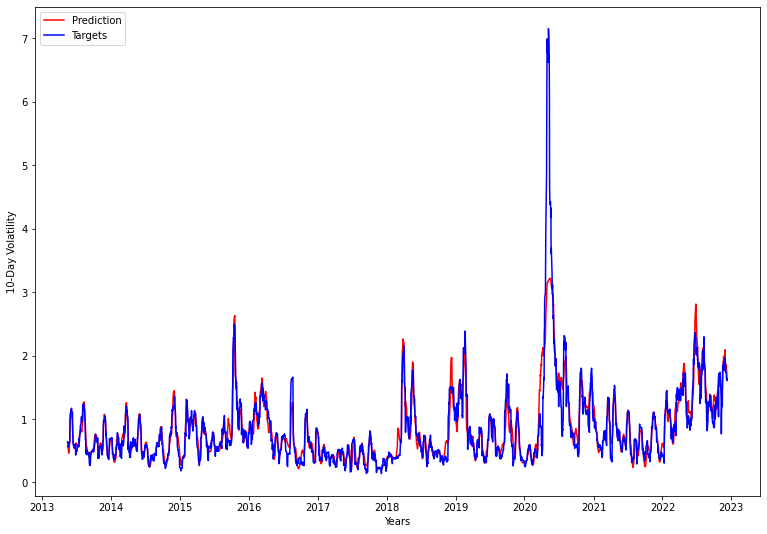

In [ ]:
df = data.copy()
df = df.tail(len(preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = preds

# Generate output
plt.figure(figsize=(13,9))
plt.plot(df.index, preds, label="Prediction", color="red")
plt.plot(df.index, targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

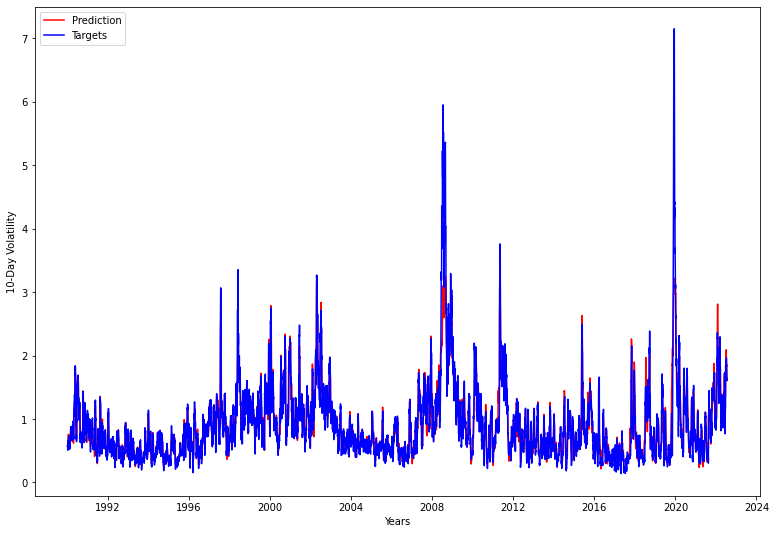

Test loss : 0.06405803


In [ ]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, vol_10, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, test_loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)